# Download packages

In [1]:
# !pip3 install gdown -q
# !pip3 install polars -q
# !pip3 install numba -q
# !pip3 install numba-progress -q

# Imports

In [1]:
import gdown
import numpy as np
import cupy as cp
import pandas as pd
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import numba as nb
from numba import njit
import time 
import os
import subprocess

%load_ext autoreload

In [2]:
from numba_functions import numba_imb_simple, numba_imb, numba_calculate_past_returns, numba_log_returns, numba_data_autocorrelation, numba_data_realized_kernel
from numpy_functions import numpy_imb_simple, numpy_imb, numpy_calculate_past_returns, numpy_log_returns, numpy_data_autocorrelation, numpy_data_realized_kernel
from cupy_functions import cupy_imb_simple, cupy_imb, cupy_calculate_past_returns, cupy_log_returns, cupy_data_autocorrelation, cupy_data_realized_kernel
%autoreload 2

# Download data

In [4]:
url = "https://drive.google.com/file/d/15E15XFVD8laDXNhw7uPpcPiWw-IGkYfv/view?usp=sharing"
output = 'book2h.parquet'
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1iTOy1bcQlgyuz-V2U-zgCFfzOuRm7NyN/view?usp=sharing"
output = "ticker2h.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1Ro-3FbjQC2FDYIg1UZG7TIFEWOQkQ4uG/view?usp=sharing"
output = "trades2h.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

'trades2h.parquet'

# Data Preparation

In [3]:
book = pl.read_parquet('book2h.parquet')
ticker = pl.read_parquet('ticker2h.parquet')
trades = pl.read_parquet('trades2h.parquet')
trades = trades.with_columns(pl.col('side').cast(pl.Float32, strict=False))

In [4]:
book_numpy = book.to_numpy()
ticker_numpy = ticker.to_numpy()
trades_numpy = trades.to_numpy()

In [5]:
# book = book.set_sorted('local_ts').with_columns(
#     pl.from_epoch(pl.col("local_ts"), time_unit="ns"))

# ticker = ticker.set_sorted('local_ts').with_columns(
#     pl.from_epoch(pl.col("local_ts"), time_unit="ns"))

# trades = trades.set_sorted('local_ts').with_columns(
#     pl.from_epoch(pl.col("local_ts"), time_unit="ns"))

# Feature generation

### order book imbalance

In [6]:
ticker_sizes_array = np.array([ticker_numpy.shape[0] // 10 for _ in range(10)])
ticker_sizes_array[np.arange(ticker_sizes_array.shape[0]) <= (ticker_numpy.shape[0] % 10)] += 1
ticker_sizes_array = np.cumsum(ticker_sizes_array)

In [14]:
numba_times = []

for size in tqdm(ticker_sizes_array):
    start = time.perf_counter()
    numba_imbalance = np.array(numba_imb_simple(ticker_numpy[:size]))
    end = time.perf_counter()
    numba_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 170.29it/s]


In [15]:
numpy_times = []

for size in tqdm(ticker_sizes_array):
    start = time.perf_counter()
    numpy_imbalance = np.array(numpy_imb_simple(ticker_numpy[:size]))
    end = time.perf_counter()
    numpy_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 132.38it/s]


In [16]:
cupy_times_no_load = []

for size in tqdm(ticker_sizes_array):
    tmp = cp.asarray(ticker_numpy[:size])
    start = time.perf_counter()
    cupy_imbalance = cupy_imb_simple(tmp).get()
    end = time.perf_counter()
    cupy_times_no_load.append(end - start)

 60%|██████    | 6/10 [00:00<00:00, 51.83it/s]

100%|██████████| 10/10 [00:00<00:00, 30.89it/s]


In [17]:
cupy_times = []

for size in tqdm(ticker_sizes_array):
    start = time.perf_counter()
    cupy_imbalance = cupy_imb_simple(cp.asarray(ticker_numpy[:size])).get()
    end = time.perf_counter()
    cupy_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 45.09it/s]


In [11]:
mpi_times = []
for size in tqdm(ticker_sizes_array):
    res = subprocess.run([f'time mpirun -n 4 --allow-run-as-root --oversubscribe python3 simple_imb_mpi.py {size-1}'], shell=True, capture_output=True)
    elapsed = float(res.stderr.decode('ascii').split('\n')[-3].split()[2][3:-7])
    mpi_times.append(elapsed)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


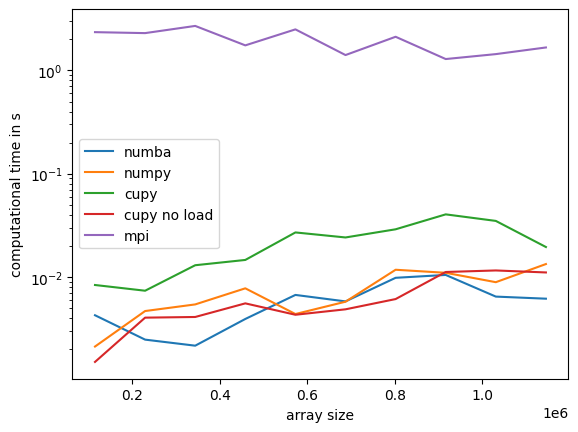

In [18]:
plt.plot(ticker_sizes_array, numba_times, label='numba')
plt.plot(ticker_sizes_array, numpy_times, label='numpy')
plt.plot(ticker_sizes_array, cupy_times, label='cupy')
plt.plot(ticker_sizes_array, cupy_times_no_load, label='cupy no load')
plt.plot(ticker_sizes_array, mpi_times, label='mpi')
plt.xlabel('array size')
plt.ylabel('computational time in s')
plt.legend()
plt.yscale('log')

plt.show()

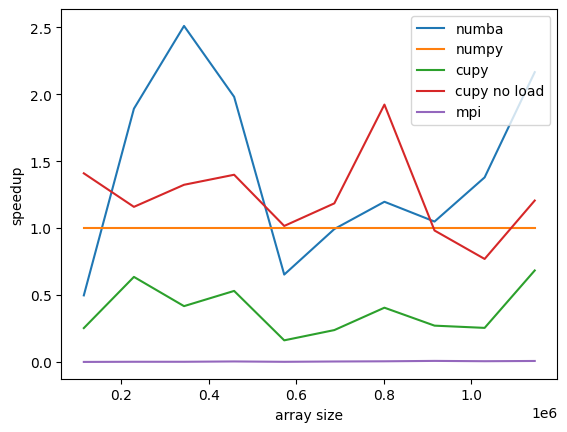

In [19]:
plt.plot(ticker_sizes_array, np.array(numpy_times) / np.array(numba_times) , label='numba')
plt.plot(ticker_sizes_array, np.array(numpy_times) / np.array(numpy_times), label='numpy')
plt.plot(ticker_sizes_array, np.array(numpy_times) / np.array(cupy_times), label='cupy')
plt.plot(ticker_sizes_array, np.array(numpy_times) / np.array(cupy_times_no_load), label='cupy no load')
plt.plot(ticker_sizes_array, np.array(numpy_times) / np.array(mpi_times), label='mpi')
plt.xlabel('array size')
plt.ylabel('speedup')
plt.legend()

plt.show()

### Improved order book imbalances

In [20]:
ob_sizes_array = np.array([book_numpy.shape[0] // 10 for _ in range(10)])
ob_sizes_array[np.arange(ob_sizes_array.shape[0]) <= (book_numpy.shape[0] % 10)] += 1
ob_sizes_array = np.cumsum(ob_sizes_array)

In [21]:
numba_times = []

for size in tqdm(ob_sizes_array):
    start = time.perf_counter()
    numba_imbalance = np.array(numba_imb(book_numpy[:size]))
    end = time.perf_counter()
    numba_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


In [22]:
numpy_times = []

for size in tqdm(ob_sizes_array):
    start = time.perf_counter()
    numpy_imbalance = np.array(numpy_imb(book_numpy[:size]))
    end = time.perf_counter()
    numpy_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:19<00:00, 19.91s/it]


In [ ]:
cupy_times = []

for size in tqdm(ob_sizes_array):
    start = time.perf_counter()
    cupy_imbalance = np.array(cupy_imb(book_numpy[:size]))
    end = time.perf_counter()
    cupy_times.append(end - start)

  0%|          | 0/177479 [00:00<?, ?it/s]100%|██████████| 177479/177479 [08:50<00:00, 334.36it/s]


In [23]:
mpi_times = []
for size in tqdm(ob_sizes_array):
    res = subprocess.run([f'time mpirun -n 4 --allow-run-as-root --oversubscribe python3 imb_mpi.py {size-1}'], shell=True, capture_output=True)
    elapsed = float(res.stderr.decode('ascii').split('\n')[-3].split()[2][3:-7])
    mpi_times.append(elapsed)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:38<00:00, 15.87s/it]


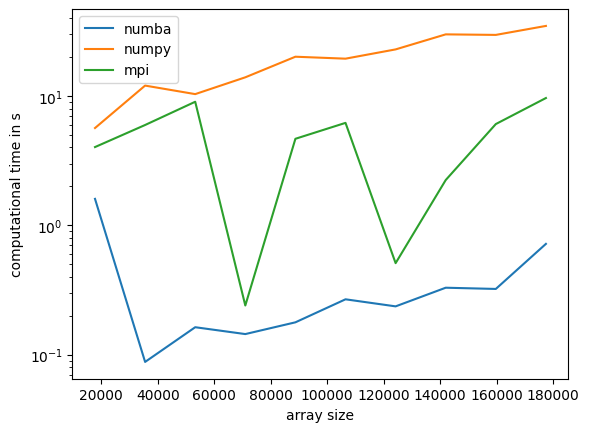

In [24]:
plt.plot(ob_sizes_array, numba_times, label='numba')
plt.plot(ob_sizes_array, numpy_times, label='numpy')
plt.plot(ob_sizes_array, mpi_times, label='mpi')
plt.xlabel('array size')
plt.ylabel('computational time in s')
plt.legend()
plt.yscale('log')

plt.show()

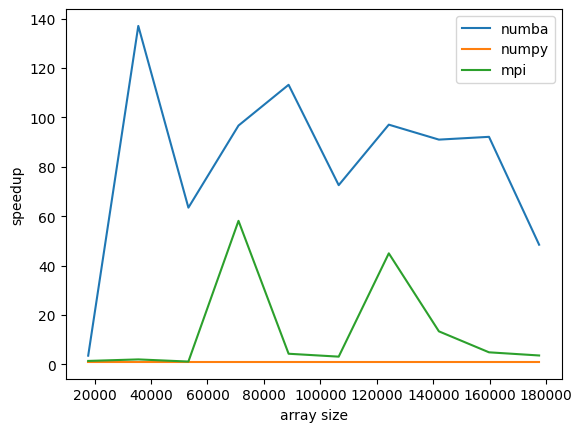

In [25]:
plt.plot(ob_sizes_array, np.array(numpy_times) / np.array(numba_times) , label='numba')
plt.plot(ob_sizes_array, np.array(numpy_times) / np.array(numpy_times), label='numpy')
plt.plot(ob_sizes_array, np.array(numpy_times) / np.array(mpi_times), label='mpi')
plt.xlabel('array size')
plt.ylabel('speedup')
plt.legend()


plt.show()

### Past returns

In [26]:
trades_sizes_array = np.array([trades_numpy.shape[0] // 10 for _ in range(10)])
trades_sizes_array[np.arange(trades_sizes_array.shape[0]) <= (trades_numpy.shape[0] % 10)] += 1
trades_sizes_array = np.cumsum(trades_sizes_array)

In [ ]:
past_returns_window = 50

In [ ]:
numba_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numba_past_return = np.array(numba_calculate_past_returns(trades_numpy[:size].astype(float), past_returns_window))
    end = time.perf_counter()
    numba_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 27.55it/s]


In [ ]:
numpy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numpy_past_return = np.array(numpy_calculate_past_returns(trades_numpy[:size].astype(float), past_returns_window))
    end = time.perf_counter()
    numpy_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:14<00:00,  7.45s/it]


In [ ]:
cupy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    cupy_past_return = np.array(cupy_calculate_past_returns(trades_numpy[:size].astype(float), past_returns_window))
    end = time.perf_counter()
    cupy_times.append(end - start)

### Log returns

In [27]:
numba_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numba_log_ret = np.array(numba_log_returns(trades_numpy[:size][:, 1].astype(float)))
    end = time.perf_counter()
    numba_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 29.49it/s]


In [28]:
numpy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numpy_log_ret = np.array(numpy_log_returns(trades_numpy[:size][:, 1].astype(float)))
    end = time.perf_counter()
    numpy_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 326.24it/s]


In [29]:
mpi_times = []
for size in tqdm(trades_sizes_array):
    res = subprocess.run([f'time mpirun -n 4 --allow-run-as-root --oversubscribe python3 logs_mpi.py {size-1}'], shell=True, capture_output=True)
    elapsed = float(res.stderr.decode('ascii').split('\n')[-3].split()[2][3:-7])
    mpi_times.append(elapsed)

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


In [31]:
cupy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    cupy_log_ret = cupy_log_returns(trades_numpy[:size][:, 1].astype(float)).get()
    end = time.perf_counter()
    cupy_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 168.50it/s]


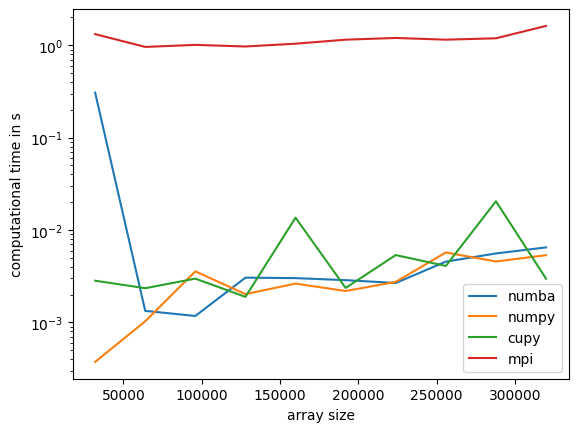

In [32]:
plt.plot(trades_sizes_array, numba_times, label='numba')
plt.plot(trades_sizes_array, numpy_times, label='numpy')
plt.plot(trades_sizes_array, cupy_times, label='cupy')
plt.plot(trades_sizes_array, mpi_times, label='mpi')
plt.xlabel('array size')
plt.ylabel('computational time in s')
plt.legend()
plt.yscale('log')

plt.show()

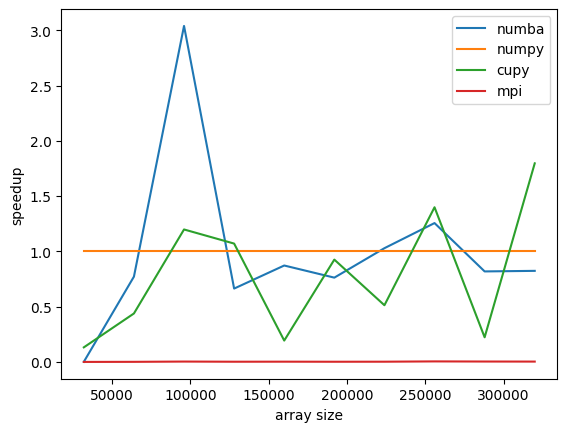

In [33]:
plt.plot(trades_sizes_array, np.array(numpy_times) / np.array(numba_times) , label='numba')
plt.plot(trades_sizes_array, np.array(numpy_times) / np.array(numpy_times), label='numpy')
plt.plot(trades_sizes_array, np.array(numpy_times) / np.array(cupy_times), label='cupy')
plt.plot(trades_sizes_array, np.array(numpy_times) / np.array(mpi_times), label='mpi')
plt.xlabel('array size')
plt.ylabel('speedup')
plt.legend()

plt.show()

### Autocorrelation

In [ ]:
autocorrelation_time_window = 10**5 # ms
lags = np.array([1])

In [ ]:
log_ret = np.stack([numba_log_ret, trades_numpy[1:, 0]], axis=1)

In [ ]:
numba_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    autocorrelations_per_lag = np.array(numba_data_autocorrelation(log_ret[:size], lags, autocorrelation_time_window))
    end = time.perf_counter()
    numba_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 35.02it/s]


In [ ]:
numpy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    autocorrelations_per_lag = np.array(numpy_data_autocorrelation(log_ret[:size], lags, autocorrelation_time_window))
    end = time.perf_counter()
    numpy_times.append(end - start)

In [ ]:
cupy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    autocorrelations_per_lag = np.array(numpy_data_autocorrelation(log_ret[:size], lags, autocorrelation_time_window))
    end = time.perf_counter()
    cupy_times.append(end - start)

### Realized kernel

In [ ]:
H = 3

In [ ]:
numba_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    realized_kernel_per_H = np.array(numba_data_realized_kernel(log_ret[:size], H, autocorrelation_time_window))
    end = time.perf_counter()
    numba_times.append(end - start)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  8.92it/s]


In [ ]:
numpy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    realized_kernel_per_H = np.array(numpy_data_realized_kernel(log_ret[:size], H, autocorrelation_time_window))
    end = time.perf_counter()
    numpy_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 13.67it/s]


In [ ]:
cupy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    realized_kernel_per_H = np.array(numpy_data_realized_kernel(log_ret[:size], H, autocorrelation_time_window))
    end = time.perf_counter()
    cupy_times.append(end - start)